In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
from pathlib import Path
from tqdm.auto import tqdm

import pandas as pd
import gzip
import json

import pickle

import numpy as np
import matplotlib.pyplot as plt

import ray
import dask.dataframe as dd

import text2code_dataset.dataset.gharchive.parser as parser
from toolkit_run.ray.server import LabRayToolkitServer

In [ ]:
def enum_jsongz_lines(file):
    with gzip.open(file, "r") as f:
        for line in f:
            try:
                data = json.loads(line)
                if data is None:
                    continue
                yield data
            except Exception:
                continue
                
def parse_watch_event(line):
    return {
        'repo_name': line['repo']['name'],
        'date': line['created_at'],
    }
           
def process_archive(filename):
    name = filename.stem
    data = []
    for line in enum_jsongz_lines(filename):
        if line['type'] == 'WatchEvent':
            data.append(parse_watch_event(line))
    if len(data) == 0:
        return
    df = pd.DataFrame(data)
    df.to_parquet(Path('/repo_workdir/watchers') / f'{name}.parquet')
    
process_archive_ray = ray.remote(process_archive)

In [ ]:
path = Path('/dataset/gharchives_2015')

In [ ]:
files = path.glob('*')

In [ ]:
files = list(files)

In [ ]:
len(files)

In [ ]:
pull_request_events = set([
    'WatchEvent',
    #'PullRequestReviewCommentEvent',
    #'PullRequestReviewEvent'
])
pull_requests = []
to_break = False
for file in tqdm(files[0:]):
    for line in enum_jsongz_lines(file):
        event_type = line['type']
        if event_type in pull_request_events:
            print(file)
            to_break = True
            break
    if to_break:
        break
    


In [ ]:
line

In [ ]:
server = LabRayToolkitServer()

In [ ]:
server.dashboard_url

In [ ]:
server.scale_cluster(60)

In [ ]:
process_archive(files[0])

In [ ]:
res = []
for file in files:
    res.append(process_archive_ray.remote(file))
ray.get(res)

In [ ]:
server.scale_cluster(0)

In [ ]:
ddf = dd.read_parquet('/repo_workdir/watchers/*.parquet')

In [ ]:
df = ddf.compute()

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df = df.sort_values('date')

In [ ]:
grouped = df.groupby('repo_name')

In [ ]:
df1 = grouped.count()

In [ ]:
df1['min_date'] = grouped.first()

In [ ]:
df1['max_date'] = grouped.last()

In [ ]:
df1 = df1.rename(columns={"date": "count"})

In [ ]:
df1 = df1.reset_index(drop=False)

In [23]:
df1 = df1.sort_values('count')

In [ ]:
df1.to_parquet('/repo_workdir/watchers/all.parquet')

In [20]:
df1 = pd.read_parquet('/repo_workdir/watchers/all.parquet')

In [24]:
df1

,repo_name,count,min_date,max_date
21461673,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz/Mirai-Source...,1,2017-12-14 20:12:21+00:00,2017-12-14 20:12:21+00:00
16994573,psyHook/Cotizador-App-React,1,2020-01-16 00:28:00+00:00,2020-01-16 00:28:00+00:00
16994572,psyHook/Books-App,1,2020-01-13 14:27:36+00:00,2020-01-13 14:27:36+00:00
16994571,psyHook/AdministradorDePacientes,1,2020-01-16 00:27:57+00:00,2020-01-16 00:27:57+00:00
9430729,cullylarson/next-css-postcss-sourcemap-issue,1,2020-01-20 12:02:53+00:00,2020-01-20 12:02:53+00:00
...,...,...,...,...
10727420,facebook/react,207812,2015-01-01 00:09:28+00:00,2022-03-31 23:57:10+00:00
18473162,sindresorhus/awesome,210996,2015-01-01 02:33:57+00:00,2022-03-31 23:59:49+00:00
20206109,vuejs/vue,223894,2015-10-18 05:21:50+00:00,2022-03-31 21:43:37+00:00
2284836,FreeCodeCamp/FreeCodeCamp,225490,2015-08-13 17:34:58+00:00,2017-01-10 04:43:44+00:00


/tmp/ipykernel_16496/3056583013.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


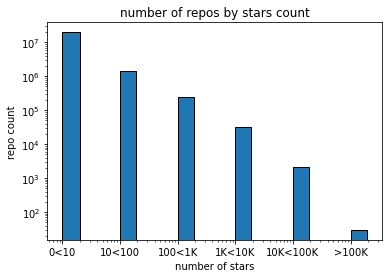

In [22]:
hist, bins = np.histogram(df1['count'], bins=[0, 10, 100, 1000, 10000, 100000, 1000000])
fig, ax = plt.subplots()
ax.bar(bins[1:], hist, width=np.diff(bins), log=True,ec="k", align="edge")
ax.set_xscale("log")
ax.set_title('number of repos by stars count')
ax.set_xlabel('number of stars')
ax.set_ylabel('repo count')

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[2] = '0<10'
labels[3] = '10<100'
labels[4] = '100<1K'
labels[5] = '1K<10K'
labels[6] = '10K<100K'
labels[7] = '>100K'

ax.set_xticklabels(labels)

plt.show()

In [3]:
files = list(Path('/dataset/repositories_zipped2_logs/indexes/repo_info/df_2022-01-24_all_licenses_no_vanity/ri').glob('data*.parquet'))

In [4]:
files += list(Path('/dataset/repositories_zipped2_logs/indexes/repo_info/df_github_v2_all_licenses_clean/ri').glob('data*.parquet'))

In [5]:
len(files)

22674

In [6]:
files[0]

PosixPath('/dataset/repositories_zipped2_logs/indexes/repo_info/df_2022-01-24_all_licenses_no_vanity/ri/data-10067.parquet')

In [7]:
df = pd.read_parquet(files[0])

In [8]:
data = []
for file in tqdm(files):
    bucket_name =  f'{file.parent.parent.stem}/{file.parent.stem}/{file.stem}'
    df = pd.read_parquet(file)
    df = df[['name']]
    df['bucket_name'] = bucket_name
    df = df.set_index('name')
    data.append(df)

  0%|          | 0/22674 [00:00<?, ?it/s]

In [ ]:
bucket_name

In [9]:
df = pd.concat(data)

In [12]:
repo_to_bucket_dict = df['bucket_name'].to_dict()

In [13]:
len(repo_to_bucket_dict)

137350429

In [16]:
%%timeit
repo_to_bucket_dict['mustakim150/work-space']

50.2 ns ± 0.33 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [19]:
with open('/repo_workdir/dataset_v2_clean_repo_to_bucket_dict.pkl', 'wb') as f:
    pickle.dump(repo_to_bucket_dict, f)